## ML Pipeline Finetuning

### Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, RocCurveDisplay, roc_auc_score, make_scorer

from src.app_func.preprocess import Preprocesor

### Import Cleaned Data

In [2]:
df = Preprocesor().preprocess_df()

In [3]:
df.isna().sum()

booking_id            0
no_show               0
branch                0
booking_month         0
arrival_month         0
arrival_day           0
checkout_month        0
checkout_day          0
country               0
first_time            0
room              21612
price             24881
platform              0
num_adults            0
num_children          0
currency          24881
SGD_price         24881
dtype: int64

### Machine learning models

- Try different Machine Learning models
- Find a Baseline model for comparison

In [4]:
drop = ["booking_id", "booking_month", "arrival_month", "arrival_day", "checkout_month", "checkout_day" , "price", "num_adults", "num_children", "currency", "room"]
df = df.drop(labels=drop, axis=1)

In [5]:
labels = ["Lowest", "Lower", "Middle" ,"Upper", "High"]
bins=5

out, b = pd.cut(df.SGD_price, bins=bins, labels=labels, ordered=True,retbins=True)
print(b)

[ 390.72247  733.936   1075.442   1416.948   1758.454   2099.96   ]


In [6]:
X = df.drop(columns=["no_show"])
Y = df["no_show"]

print(X.shape, Y.shape)
print(X.columns)

(119390, 5) (119390,)
Index(['branch', 'country', 'first_time', 'platform', 'SGD_price'], dtype='object')


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=11)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(83573, 5) (35817, 5) (83573,) (35817,)


 - Baseline accuracy if all predictions were 1

In [8]:
# Train set - Null Accuracy
null_acc_train = 1 - y_train.sum()/len(y_train)

# Test set - Null Accuracy
null_acc_test = 1 - y_test.sum()/len(y_test)

print(f"null accuracy")
print(f"Train set: {null_acc_train*100:.2f}%, Test set: {null_acc_test*100:.2f}% ")

null accuracy
Train set: 62.89%, Test set: 63.12% 


### Logistic Regression

In [10]:
lr = LogisticRegression(
                    penalty="l1",
                    solver="liblinear",
                    max_iter=50,
                    C=0.1,
                    random_state=11,
                )
price_transformer = Pipeline([
                            ("sim1", SimpleImputer(strategy="mean")),
                            ("bin1", KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="uniform"))
                        ])
ct = ColumnTransformer(
                [
                    ("ohe1", OneHotEncoder(drop="first"), ["branch", "first_time", "platform"]),
                    ("ore1", OrdinalEncoder(encoded_missing_value=-1), ["country"]),
                    ("num1", price_transformer, ["SGD_price"])
                ],
                remainder="drop",
            )
lr_pipe = Pipeline([("column_transfomer", ct), ("classifier", lr)])
lr_pipe.fit(X_train, y_train)
y_pred_train = lr_pipe.predict(X_train)

acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train)
print("Train Set")
print(f"Accuracy: {acc_train*100:.2f}%, Precision: {prec_train*100:.2f}%")

lr_pipe.fit(X_test, y_test)
y_pred_test = lr_pipe.predict(X_test)

acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
print("Test Set")
print(f"Accuracy: {acc_test*100:.2f}%, Precision: {prec_test*100:.2f}%")

Train Set
Accuracy: 69.82%, Precision: 62.42%
Test Set
Accuracy: 70.03%, Precision: 62.86%


- Grid Search for Logistic Regression

In [11]:
lr_coef = pd.DataFrame(zip(X_train.columns, np.transpose(lr.coef_)), columns=['features', 'coefficients'])

print(f"Intercept: {lr.intercept_}")
lr_coef

Intercept: [-0.94090282]


,features,coefficients
0,branch,[-0.8608327582109612]
1,country,[1.2277305215133554]
2,first_time,[0.0]
3,platform,[0.0]
4,SGD_price,[0.0027265562584785448]


In [12]:
cross_val_score(lr_pipe, X, Y, cv=5, scoring="precision").mean()

0.6281769819802969

In [13]:
params = {}
params["classifier__C"] = [0.1, 1, 10]
params["classifier__penalty"] = ["l1", "l2"]
params["classifier__max_iter"] = [50,100,150,200]

grid = GridSearchCV(lr_pipe, cv=5, param_grid=params)
grid.fit(X, Y)
print(f"Best Score: {grid.best_score_:.4f}")
print(f"Best Prams {grid.best_params_}")
grid.best_estimator_

Best Score: 0.6995
Best Prams {'classifier__C': 0.1, 'classifier__max_iter': 50, 'classifier__penalty': 'l1'}


Pipeline(steps=[('column_transfomer',
                 ColumnTransformer(transformers=[('ohe1',
                                                  OneHotEncoder(drop='first'),
                                                  ['branch', 'first_time',
                                                   'platform']),
                                                 ('ore1',
                                                  OrdinalEncoder(encoded_missing_value=-1),
                                                  ['country']),
                                                 ('num1',
                                                  Pipeline(steps=[('sim1',
                                                                   SimpleImputer()),
                                                                  ('bin1',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    strategy='uniform'))]),
                                                  ['SGD_price'])])),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=50, penalty='l1',
                                    random_state=11, solver='liblinear'))])

### Decision Tree

In [14]:
dt = DecisionTreeClassifier(
                    max_depth=5,
                    min_samples_split=3,
                    min_samples_leaf=10,
                    criterion='log_loss',
                    splitter='best',
                    random_state=11,
                )
price_transformer = Pipeline([
                            ("sim1", SimpleImputer(strategy="mean")),
                            ("bin1", KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="uniform"))
                        ])
ct = ColumnTransformer(
                [
                    ("ore2", OrdinalEncoder(encoded_missing_value=-1), ["branch", "first_time", "platform", "country"]),
                    ("num2", price_transformer, ["SGD_price"])
                ],
                remainder="drop",
            )
dt_pipe = Pipeline([("column_transfomer", ct), ("classifier", dt)])
dt_pipe.fit(X_train, y_train)
y_pred_train = dt_pipe.predict(X_train)

acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train, zero_division=0)
print("Train Set")
print(f"Accuracy: {acc_train*100:.2f}%, Precision: {prec_train*100:.2f}%")

dt_pipe.fit(X_test, y_test)
y_pred_test = dt_pipe.predict(X_test)

acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test, zero_division=0)
print("Test Set")
print(f"Accuracy: {acc_test*100:.2f}%, Precision: {prec_test*100:.2f}%")

Train Set
Accuracy: 71.75%, Precision: 69.23%
Test Set
Accuracy: 71.85%, Precision: 69.48%


In [15]:
dt_coef = pd.DataFrame(zip(X_train.columns, np.transpose(dt.feature_importances_)), columns=['features', 'feature_importances'])

dt_coef.sort_values("feature_importances", ascending=False)

,features,feature_importances
3,platform,0.670489
0,branch,0.165269
1,country,0.111167
4,SGD_price,0.051004
2,first_time,0.002071


In [16]:
params = {}
params["classifier__max_depth"] = [2, 5, 15]
params["classifier__min_samples_split"] = [2, 3, 5, 10]
params["classifier__min_samples_leaf"] = [ 10, 15, 20]
params["classifier__criterion"] = ["gini", "log_loss"]
params["classifier__splitter"] = ["best", "random"]

dt_grid = RandomizedSearchCV(dt_pipe, cv=5, param_distributions=params)
dt_grid.fit(X, Y)
print(f"Best Score: {dt_grid.best_score_:.4f}")
print(f"Best Prams {dt_grid.best_params_}")
dt_grid.best_estimator_

Best Score: 0.7178
Best Prams {'classifier__splitter': 'best', 'classifier__min_samples_split': 3, 'classifier__min_samples_leaf': 15, 'classifier__max_depth': 5, 'classifier__criterion': 'gini'}


Pipeline(steps=[('column_transfomer',
                 ColumnTransformer(transformers=[('ore2',
                                                  OrdinalEncoder(encoded_missing_value=-1),
                                                  ['branch', 'first_time',
                                                   'platform', 'country']),
                                                 ('num2',
                                                  Pipeline(steps=[('sim1',
                                                                   SimpleImputer()),
                                                                  ('bin1',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    strategy='uniform'))]),
                                                  ['SGD_price'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=15,
                                        min_samples_split=3,
                                        random_state=11))])

### Random Forest

In [18]:
rf = RandomForestClassifier(
                    n_estimators=450,
                    criterion='log_loss',
                    max_depth=15,
                    min_samples_split=50,
                    min_samples_leaf=70,
                    max_leaf_nodes=35,
                    max_features=None,
                    random_state=11
                )
price_transformer = Pipeline([
                            ("sim1", SimpleImputer(strategy="mean")),
                            ("bin1", KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="uniform"))
                        ])
ct = ColumnTransformer(
                [
                    ("ore2", OrdinalEncoder(encoded_missing_value=-1), ["branch", "first_time", "platform", "country"]),
                    ("num2", price_transformer, ["SGD_price"])
                ],
                remainder="drop",
            )
rf_pipe = Pipeline([("column_transfomer", ct), ("classifier", rf)])
rf_pipe.fit(X_train, y_train)
rf_y_pred_train = rf_pipe.predict(X_train)

acc_train = accuracy_score(y_train, rf_y_pred_train)
prec_train = precision_score(y_train, rf_y_pred_train)
print("Train Set")
print(f"Accuracy: {acc_train*100:.2f}%, Precision: {prec_train*100:.2f}%")

rf_pipe.fit(X_test, y_test)
rf_y_pred_test = rf_pipe.predict(X_test)

acc_test = accuracy_score(y_test, rf_y_pred_test)
prec_test = precision_score(y_test, rf_y_pred_test)
print("Test Set")
print(f"Accuracy: {acc_test*100:.2f}%, Precision: {prec_test*100:.2f}%")

Train Set
Accuracy: 71.75%, Precision: 69.23%
Test Set
Accuracy: 71.85%, Precision: 69.48%


In [19]:
rf_coef = pd.DataFrame(zip(X_train.columns, np.transpose(rf.feature_importances_)), columns=['features', 'feature_importances'])

rf_coef.sort_values("feature_importances", ascending=False)

,features,feature_importances
3,platform,0.671098
0,branch,0.161779
1,country,0.106549
4,SGD_price,0.051458
2,first_time,0.009115


In [20]:
params = {}
params["classifier__n_estimators"] = [600, 700]
params["classifier__criterion"] = ["gini", "log_loss"]
params["classifier__max_depth"] = [15, 20]
params["classifier__min_samples_split"] = [50, 60]
params["classifier__min_samples_leaf"] = [80, 100]
params["classifier__max_leaf_nodes"] = [40, 50]
params["classifier__max_features"] = ["sqrt", "log2", None]

rf_grid = RandomizedSearchCV(rf_pipe, cv=3, param_distributions=params, verbose=1)
rf_grid.fit(X, Y)
print(f"Best Score: {rf_grid.best_score_:.4f}")
print(f"Best Prams {rf_grid.best_params_}")
rf_grid.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Score: 0.7178
Best Prams {'classifier__n_estimators': 600, 'classifier__min_samples_split': 60, 'classifier__min_samples_leaf': 80, 'classifier__max_leaf_nodes': 40, 'classifier__max_features': 'log2', 'classifier__max_depth': 15, 'classifier__criterion': 'log_loss'}


Pipeline(steps=[('column_transfomer',
                 ColumnTransformer(transformers=[('ore2',
                                                  OrdinalEncoder(encoded_missing_value=-1),
                                                  ['branch', 'first_time',
                                                   'platform', 'country']),
                                                 ('num2',
                                                  Pipeline(steps=[('sim1',
                                                                   SimpleImputer()),
                                                                  ('bin1',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    strategy='uniform'))]),
                                                  ['SGD_price'])])),
                ('classifier',
                 RandomForestClassifier(criterion='log_loss', max_depth=15,
                                        max_features='log2', max_leaf_nodes=40,
                                        min_samples_leaf=80,
                                        min_samples_split=60, n_estimators=600,
                                        random_state=11))])

AUC-ROC Curves

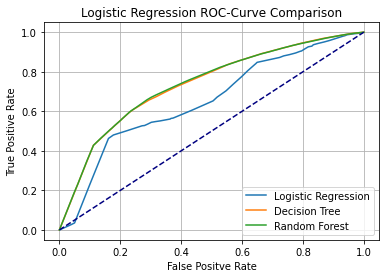

Logistic Regression ROC-Score: 0.6543
Decision Tree Classifier ROC-Score: 0.7328
Random Forest Classifier ROC-Score: 0.7356


In [21]:

dis = RocCurveDisplay.from_estimator(lr_pipe, X, Y, label="Logistic Regression")
RocCurveDisplay.from_estimator(dt_pipe, X, Y, ax=dis.ax_, label="Decision Tree")
RocCurveDisplay.from_estimator(rf_pipe, X, Y, ax=dis.ax_, label="Random Forest")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.title("Logistic Regression ROC-Curve Comparison")
plt.xlabel("False Positve Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

lr_roc_score = roc_auc_score(y_test, lr_pipe.predict_proba(X_test)[:,1])
dt_roc_score = roc_auc_score(y_test, dt_pipe.predict_proba(X_test)[:,1])
rf_roc_score = roc_auc_score(y_test, rf_pipe.predict_proba(X_test)[:,1])
print(f"Logistic Regression ROC-Score: {lr_roc_score:.4f}")
print(f"Decision Tree Classifier ROC-Score: {dt_roc_score:.4f}")
print(f"Random Forest Classifier ROC-Score: {rf_roc_score:.4f}")

In [13]:
import pandas as pd
from src.app_func.preprocess import Preprocesor
from src.app_func.mlpipe import MLpipeline

df = Preprocesor().preprocess_df()
drop = ["booking_id", "booking_month", "arrival_month", "arrival_day", "checkout_month", "checkout_day" , "price", "num_adults", "num_children", "currency", "room"]
df = df.drop(labels=drop, axis=1)

country = "China"
platform = "Website"
branch = "Changi"
first_time = "True"
amount = 1000.00

pred_row = pd.DataFrame({"country": str(country), "platform": str(platform), "branch": str(branch), "first_time":bool(first_time), "SGD_price": float(amount) }, index=[0])

model_name, y_pred_prob, y_pred_test = MLpipeline().frontend_output(df, pred_row)
y_pred_test = y_pred_test[0]
if y_pred_test:
    y_pred_prob = y_pred_prob[0][1]
else:
    y_pred_prob = y_pred_prob[0][0]

print(f"The model predicts No-Show to be {y_pred_test}.")
print(f"The prediction probability is {y_pred_prob:.4f}.")
print(f"The model used for prediction was {model_name}.")

The model predicts No-Show to be True.
The prediction probability is 0.6923.
The model used for prediction was Decision Tree Classifier.
